This notebook:
- Reads a stacked dataset from Google Cloud
- Annotates the stacked dataset in order to calculate INEXUS
- Generates a sub-datafile with only the variables of interest
- Plots INEXUS

In [1]:
import os
import os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid", color_codes=True)
sns.set(font_scale=1.35, style="ticks") #set styling preferences

Import Stacked file from Google Cloud

In [2]:
%%time
# Stacked File without outliers (removed by isolation forest)
sf_stacked_rh_price = pd.read_csv('gs://beam-core-analysis/CordonPricing/sf_2018_stacked_cordonpricing_20230724.csv.gz', compression = 'gzip')
#stacked_rh_path = "https://beam-core-act.s3.amazonaws.com/deepDive/CleanData/SanFrancisco/Stacked/"
#sf_stacked_rh_price = pd.read_csv(stacked_rh_path + 'sf_2018_stacked_rh_price_clean_ML_5_11_23.csv') #usecols = cols_to_use

<timed exec>:2: DtypeWarning: Columns (96,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,149,158,163,165,166,167,168,170,171,228,229,230,231,240) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 9min 57s
Wall time: 11min 15s


Define a function to keep the variables of interest and split into income ranks.
- Input: Stacked dataframe
- Output: Reduced form dataframe for INEXUS analysis

In [51]:
def process_income_data(dataframe):
    small_stacked_rh_price = dataframe[['toll','income_deciles','IDMerged','tripIndex',
                                        'income', 
                                        'Realized_INEXUS_in_dollar_2023', 'potential_in_dollar_2023_relative_to_baseline',
                                        'realized_in_dollar_2023_relative_to_baseline',
                                        'Potential_INEXUS_in_dollar_2023', 'mode_choice_actual_4', 'duration_door_to_door',
                                        'waitTime_no_replanning','waitTime_replanning', 'mode_choice_planned_BEAM',
                                        'mode_choice_actual_BEAM']]
    
    small_stacked_rh_price['incomeInThousands'] = small_stacked_rh_price['income'] / 1000
    
    person_income = pd.pivot_table(
        small_stacked_rh_price,
        index=['IDMerged'],
        aggfunc={'incomeInThousands': lambda x: ', '.join(set(x.dropna().astype(str)))}).reset_index()
    
    person_income['incomeInThousands'] = person_income['incomeInThousands'].astype(float)
    
    twenty_one_ranks = person_income['incomeInThousands'].quantile([
        0, 0.048, 0.095, 0.143, 0.191, 0.239, 0.287, 0.335, 0.383, 0.431, 0.479,
        0.527, 0.575, 0.623, 0.671, 0.719, 0.767, 0.815, 0.863, 0.911, 0.959, 1
    ]).tolist()
    
    conditions = [
        (person_income['incomeInThousands'] >= twenty_one_ranks[i]) & 
        (person_income['incomeInThousands'] <= twenty_one_ranks[i+1])
        for i in range(21)
    ]
    
    choices = list(range(21))
    
    person_income['incomeRank'] = np.select(conditions, choices, default=None)
    
    smaller_stacked_rh_price = pd.merge(left = small_stacked_rh_price, right = person_income, how='left', on = ['IDMerged'], suffixes=('', '_drop'))
    smaller_stacked_rh_price.drop([col for col in smaller_stacked_rh_price.columns if 'drop' in col], axis=1, inplace=True)
    
    lorenz_data = pd.pivot_table(
        smaller_stacked_rh_price,
        index=['toll', 'incomeRank'],
        aggfunc={'incomeInThousands': np.mean,
                 'Potential_INEXUS_in_dollar_2023': np.mean,
                 'Realized_INEXUS_in_dollar_2023': np.mean}).reset_index() 
    return lorenz_data

I am keeping the 'sf_stacked' convention for simplicity as I inherited this code

In [52]:
sf_stacked = sf_stacked_rh_price

Data cleaning/prep

In [53]:
# Mapping BEAM and ActivitySim modes (The ones in this cell are the most promising matches)
conditions  = [(sf_stacked['mode_choice_actual_BEAM'] == 'walk')&(sf_stacked['trip_mode_AS_trips'] == 'WALK'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'bike')&(sf_stacked['trip_mode_AS_trips'] == 'BIKE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'car_hov3')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'car_hov3')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'car_hov2')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'car_hov2')&(sf_stacked['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'car')&(sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEFREE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'car')&(sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEPAY'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_stacked['trip_mode_AS_trips'] == 'WALK_LRF'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_stacked['trip_mode_AS_trips'] == 'WALK_LOC'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_stacked['trip_mode_AS_trips'] == 'WALK_EXP'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_stacked['trip_mode_AS_trips'] == 'WALK_HVY'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_stacked['trip_mode_AS_trips'] == 'WALK_COM'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_stacked['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_stacked['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_stacked['trip_mode_AS_trips'] == 'TAXI'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_COM'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_LRF'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_LOC'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_EXP'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_HVY'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_stacked['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_stacked['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_stacked['trip_mode_AS_trips'] == 'TAXI'),
       
               (sf_stacked['mode_choice_actual_BEAM'] == 'hov2_teleportation')&((sf_stacked['trip_mode_AS_trips'] == 'SHARED3FREE')|
               (sf_stacked['trip_mode_AS_trips'] == 'SHARED3PAY')|(sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'car_hov2')&((sf_stacked['trip_mode_AS_trips'] == 'SHARED3PAY')|
               (sf_stacked['trip_mode_AS_trips'] == 'SHARED3FREE')|(sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'car_hov3')&((sf_stacked['trip_mode_AS_trips'] == 'SHARED2PAY')|
               (sf_stacked['trip_mode_AS_trips'] == 'SHARED2FREE')|(sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),   
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'hov3_teleportation')&((sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEPAY')|
               (sf_stacked['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|(sf_stacked['trip_mode_AS_trips'] == 'SHARED2PAY')|(sf_stacked['trip_mode_AS_trips'] == 'SHARED2FREE')),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'car')&((sf_stacked['trip_mode_AS_trips'] == 'SHARED3FREE')|(sf_stacked['trip_mode_AS_trips'] == 'SHARED2FREE')|
               (sf_stacked['trip_mode_AS_trips'] == 'SHARED3PAY')|(sf_stacked['trip_mode_AS_trips'] == 'SHARED2PAY')|(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_LOC')|
               (sf_stacked['trip_mode_AS_trips'] == 'DRIVE_LRF')|(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_EXP')|
               (sf_stacked['trip_mode_AS_trips'] == 'DRIVE_HVY')|(sf_stacked['trip_mode_AS_trips'] == 'DRIVE_COM')),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk')&((sf_stacked['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sf_stacked['trip_mode_AS_trips'] == 'WALK_LOC')|(sf_stacked['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sf_stacked['trip_mode_AS_trips'] == 'WALK_HVY')|(sf_stacked['trip_mode_AS_trips'] == 'WALK_COM')),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_stacked['trip_mode_AS_trips'] == 'WALK'),
               
               ((sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail_pooled')|(sf_stacked['mode_choice_actual_BEAM'] == 'ride_hail'))
               &(~((sf_stacked['trip_mode_AS_trips'] == 'TAXI')|(sf_stacked['trip_mode_AS_trips'] == 'TNC_SHARED')|
                (sf_stacked['trip_mode_AS_trips'] == 'TNC_SINGLE'))),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')&(~((sf_stacked['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sf_stacked['trip_mode_AS_trips'] == 'WALK_LOC')|(sf_stacked['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sf_stacked['trip_mode_AS_trips'] == 'WALK_HVY')|(sf_stacked['trip_mode_AS_trips'] == 'WALK_COM')|
               (sf_stacked['trip_mode_AS_trips'] == 'WALK'))),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'bike_transit'),
               
               (sf_stacked['mode_choice_actual_BEAM'] == 'car')&((sf_stacked['trip_mode_AS_trips'] == 'TNC_SHARED')|
               (sf_stacked['trip_mode_AS_trips'] == 'TNC_SINGLE')|(sf_stacked['trip_mode_AS_trips'] == 'TAXI'))]
 
                                                                      
                                                                                                                 
                                                                      
choices = [sf_stacked['WALK'], sf_stacked['BIKE'], sf_stacked['SHARED3FREE'], sf_stacked['SHARED3PAY'],
           sf_stacked['SHARED3FREE'], sf_stacked['SHARED3PAY'], sf_stacked['SHARED2FREE'], 
           sf_stacked['SHARED2PAY'], sf_stacked['SHARED2PAY'], sf_stacked['SHARED2FREE'], 
           sf_stacked['DRIVEALONEFREE'], sf_stacked['DRIVEALONEPAY'], sf_stacked['WALK_LRF'], 
           sf_stacked['WALK_LOC'], sf_stacked['WALK_EXP'], sf_stacked['WALK_HVY'], sf_stacked['WALK_COM'],
           sf_stacked['TNC_SINGLE'], 
           sf_stacked['TNC_SHARED'], sf_stacked['TAXI'],
           sf_stacked['DRIVE_COM'], sf_stacked['DRIVE_LRF'], sf_stacked['DRIVE_LOC'], sf_stacked['DRIVE_EXP'],
           sf_stacked['DRIVE_HVY'], sf_stacked['TNC_SINGLE'], sf_stacked['TNC_SHARED'], sf_stacked['TAXI'],
          sf_stacked[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_stacked[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_stacked[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_stacked[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_stacked[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_stacked[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
          sf_stacked[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
          sf_stacked[['TAXI','TNC_SINGLE','TNC_SHARED']].max(axis=1),
          sf_stacked[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_stacked[['BIKE','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_stacked[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1)]

Define realised INEXUS

In [54]:
sf_stacked['Realized_INEXUS'] = np.select(conditions, choices, default=np.nan)

In [55]:
# I separated this part and the following two because they are not as strong matches of the modes as the first group
sf_stacked['Realized_INEXUS'] = np.where((sf_stacked['Realized_INEXUS'].isna())&((sf_stacked['mode_choice_actual_BEAM'] == 'car_hov2')|
                                          (sf_stacked['mode_choice_actual_BEAM'] == 'car_hov3')|
                                          (sf_stacked['mode_choice_actual_BEAM'] == 'hov2_teleportation')|
                                          (sf_stacked['mode_choice_actual_BEAM'] == 'hov3_teleportation')|
                                          (sf_stacked['mode_choice_actual_BEAM'] == 'car')|
                                          (sf_stacked['mode_choice_actual_BEAM'] == 'drive_transit')), 
                                           sf_stacked[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1), sf_stacked['Realized_INEXUS'])

In [56]:
sf_stacked['Realized_INEXUS'] = np.where((sf_stacked['Realized_INEXUS'].isna())&((sf_stacked['mode_choice_actual_BEAM'] == 'walk')|
                                         (sf_stacked['mode_choice_actual_BEAM'] == 'walk_transit')), 
                                          sf_stacked[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),sf_stacked['Realized_INEXUS'])

In [57]:
sf_stacked['Realized_INEXUS'] = np.where(sf_stacked['Realized_INEXUS'].isna()&(sf_stacked['mode_choice_actual_BEAM'] == 'bike'), 
                                         sf_stacked[['BIKE','WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),sf_stacked['Realized_INEXUS'])

In [58]:
# dropping the rows with NAN utility values
sf_stacked.dropna(subset=['Realized_INEXUS'], inplace=True)

IVT and alphas

In [59]:
# Function to calculate c_ivt based on primary_purpose
def calculate_in_vehicle_time_coefficient(primary_purpose):
    conditions = [
        (primary_purpose == 'work'),
        (primary_purpose == 'univ'),
        (primary_purpose == 'school'),
        (primary_purpose == 'escort'),
        (primary_purpose == 'shopping'),
        (primary_purpose == 'eatout'),
        (primary_purpose == 'othmaint'),
        (primary_purpose == 'social'),
        (primary_purpose == 'othdiscr'),
        (primary_purpose == 'atwork')
    ]
    
    choices = [-0.022, -0.0271, -0.0271, -0.0279, -0.0279, -0.0279, -0.0175, -0.0175, -0.0279, -0.0279]
    
    return np.select(conditions, choices, default=np.nan)

In [60]:
# Calculate c_ivt and assign it to 'c_ivt' column
sf_stacked['c_ivt'] = calculate_in_vehicle_time_coefficient(sf_stacked['primary_purpose_x'])

In [61]:
# Calculate alpha based on 'c_ivt' and 'value_of_time'
sf_stacked['alpha'] = -0.6 * (sf_stacked['c_ivt']) / (sf_stacked['value_of_time'])

Turn into dollars and calculate social INEXUS

In [62]:
# Calculate the Realized INEXUS in_dollar - Multiply by 1.75 to convert it to the 2023 dollar value
sf_stacked['Realized_INEXUS_in_dollar_2023'] = ((sf_stacked['Realized_INEXUS'] / sf_stacked['alpha']) / 100) * 1.75

In [63]:
# Calculate the Potential INEXUS in dollar - Multiply by 1.75 to convert it to the 2023 dollar value 
sf_stacked['Potential_INEXUS_in_dollar_2023'] = ((sf_stacked['logsum_trip_Potential_INEXUS'] / sf_stacked['alpha']) / 100) * 1.75

In [64]:
sf_stacked['socialCarbonCost'] = sf_stacked['emission_marginal'] * 185

In [65]:
sf_stacked['Social_INEXUS'] = (sf_stacked['Realized_INEXUS_in_dollar_2023'] / sf_stacked['alpha']) - sf_stacked['socialCarbonCost']

Now call the function

In [66]:
lorenz_data = process_income_data(sf_stacked)

C:\Users\cguirado\AppData\Local\Temp\2\ipykernel_2292\111766942.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_stacked_rh_price['incomeInThousands'] = small_stacked_rh_price['income'] / 1000


Prepare to plot

In [67]:
palette = {
    8: '#521e4d',
    5: '#8e1d5b',
    3: '#ad1759',
    1.75: '#ca1a50',
    1: '#e13243',
    0.5: '#ee543f',
    0.25: '#f37751',
    0.125: '#f5966d',
    0: '#f7d0b5'}

C:\Users\cguirado\AppData\Local\Temp\2\ipykernel_2292\2900738727.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(data = lorenz_data, x = (lorenz_data['incomeRank'])*5,


ValueError: Could not interpret value `potential_in_dollar_2023_relative_to_baseline` for parameter `y`

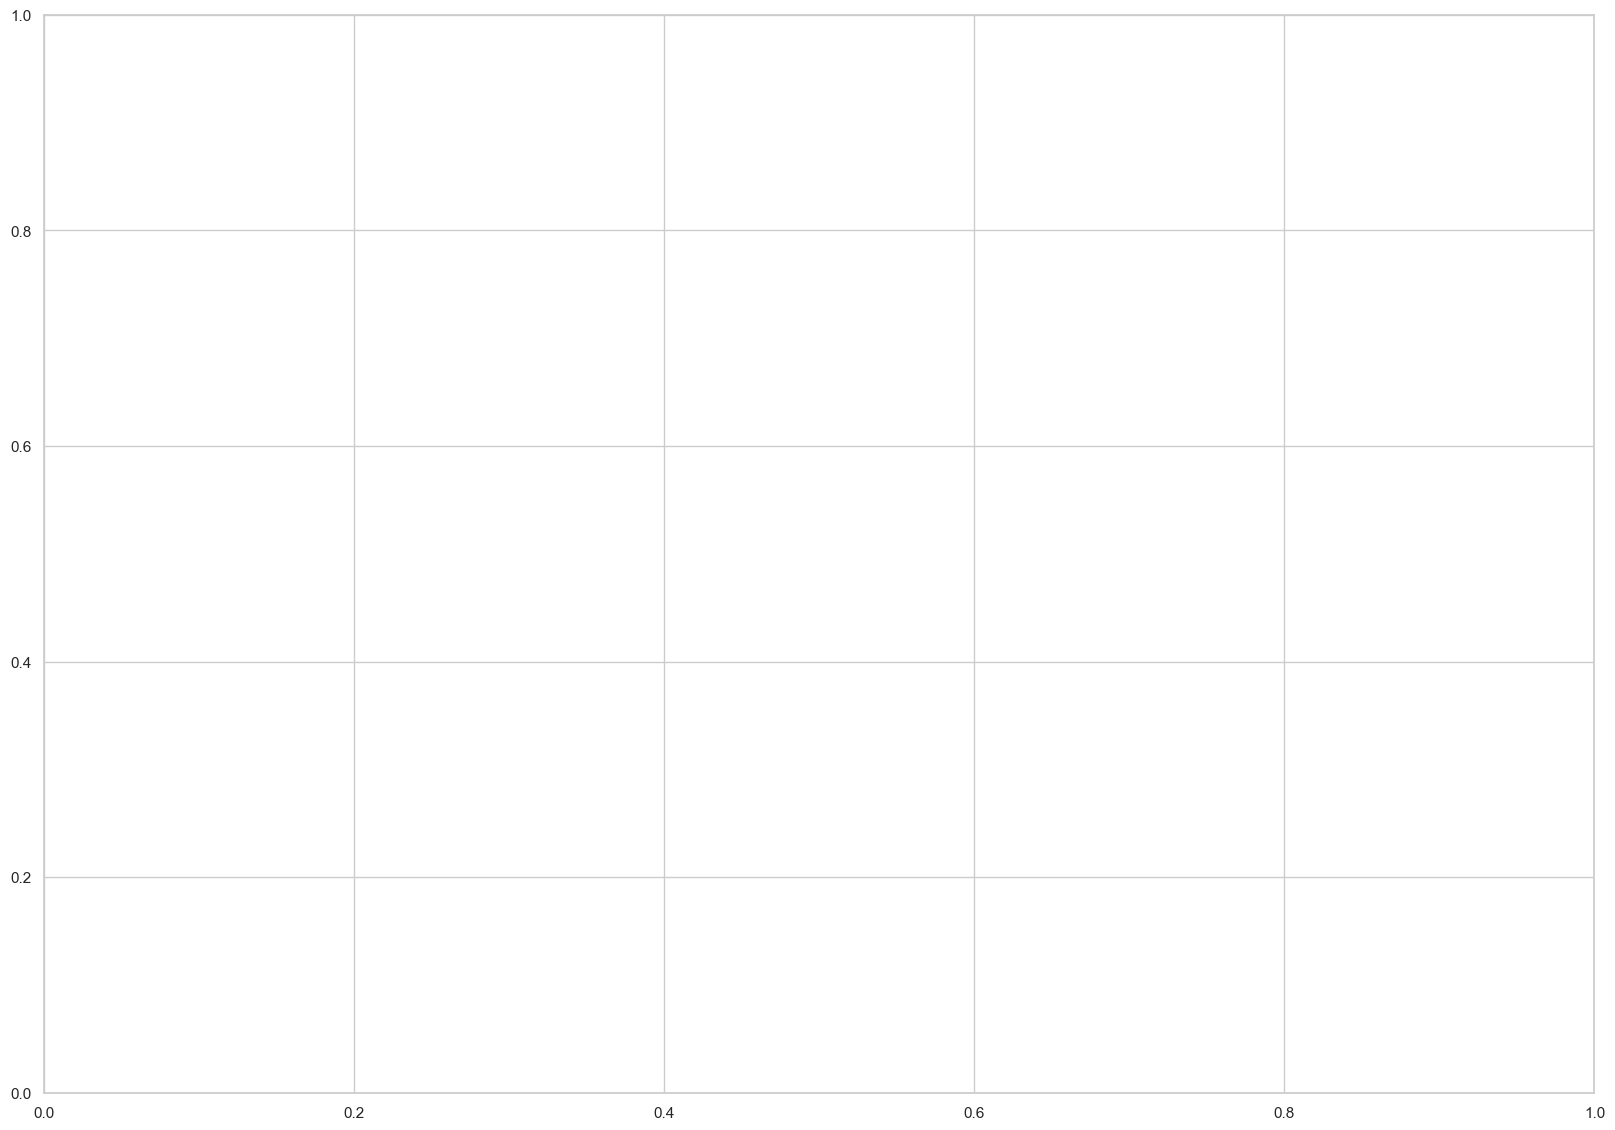

In [69]:
import matplotlib.ticker as ticker
sns.set(rc={'figure.figsize':(20,14)})
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = lorenz_data, x = (lorenz_data['incomeRank'])*5, 
                  y = 'potential_in_dollar_2023_relative_to_baseline', hue = 'lever_position_price', palette = palette, ci=None, linewidth = 6)
ax.set_xlabel('Income Rank (Percentiles of Income)', fontsize = 36) #45
ax.set_ylabel('Potential INEXUS ($) relative to Baseline', fontsize = 36) #45
ax.yaxis.set_tick_params(labelsize = 26) #35
ax.xaxis.set_tick_params(labelsize = 26) #35
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x)}%'))
plt.legend(labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'],
         fontsize='medium', fancybox=False, bbox_to_anchor=(1, 0.8), ncol=1, frameon=True, loc = 'best', prop={'size': 26}) #35
#plt.savefig('lorenz.svg', format='svg', bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], fancybox=False, bbox_to_anchor=(1, 0.8), fontsize=26),), bbox_inches='tight') #30
#plt.savefig('lorenz.png', dpi=300)